In [2]:
from ngsolve import *
#from ngsolve.webgui import Draw
from netgen.occ import *
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

def matvec_b(v):
    tmp1.data = v
    tmp2.data = b * tmp1
    return tmp2.FV().NumPy()


def matvec_c(v):
    tmp3.data = v
    tmp4.data = c.mat * tmp3
    return tmp4.FV().NumPy()

In [3]:
#TODO inverses are bad -> assume that this is issue with the matrix to be inverted, dual makes issues, how to treat boundry vertices
#Issue constructed matrix is not Invertible
#TODO find out why entries on diagonal are zero (should be inner product of primal basis function and dual basis function on same edge ->should not be zero)
def HDiv_Primal_Dual_L2IP(mesh):
    pe = mesh.edges
    ne = mesh.nedge
    pv = mesh.vertices
    nv = len(pv)
    #Setup

    #for fine to coarse mapping
    ref_space = Compress(HDiv(mesh, order=0, RT=True))#, dirichlet="bottom|right|left|top"))
    #print(ref_space.FreeDofs())

    elnrs = np.ones((ne,3),dtype=int)
    for e in mesh.edges:
        el1 = mesh.__getitem__(e.elements[0])
        elnrs[e.nr,2] = ref_space.GetDofNrs(e)[0]
        elnrs[e.nr,0:2] = el1.nr
        if len(e.elements) == 2:
            el2 = mesh.__getitem__(e.elements[1])
            elnrs[e.nr,1] = el2.nr

    #print(elnrs[:,:])

    #Barycentric Refinement
    mesh.ngmesh.SplitPowellSabin()

    #for fine to coarse mapping
    fes_primal = Compress(HDiv(mesh, order=0, RT=True))#, dirichlet="bottom|right|left|top"))

    Hdiv_u = fes_primal.TrialFunction()
    Hdiv_v = fes_primal.TestFunction()

    #for mapping to dual
    fes_dual = Compress(HCurl(mesh, order=1, type1=True))#, dirichlet="bottom|right|left|top")) #Compress(HDiv(mesh, order=0, RT=True)) #

    Hcurl_u = fes_dual.TrialFunction()
    Hcurl_v = fes_dual.TestFunction()

    #L2 inner product of H1 and L2 basis function on barycentrically refined mesh
    HD_HC_L2IP = BilinearForm(trialspace=fes_primal, testspace=fes_dual) #fes_dual)
    HD_HC_L2IP += Hdiv_u * Hcurl_v * dx

    HD_HC_L2IP.Assemble()
    #print(HD_HC_L2IP.mat.shape)

    # mapping to dual ---------------------------------------------------------------------------------------------------------
    data_length = 0
    for e in pe:
        # if elnrs[e.nr, 0] == elnrs[e.nr,1]:
        #     #boundryEdge = True
        #     continue        
        for v in e.vertices:
            v = mesh.__getitem__(v)
            data_length += len(v.edges) + 2


    data = np.zeros(data_length)
    row_ind = np.zeros(data_length, dtype=int)
    col_ind = np.zeros(data_length, dtype=int)

    j = 0

    for e in pe:
        parent = elnrs[e.nr,2]  
        #print(parent)
        v0 = e.vertices[0]  
        v1 = e.vertices[1] 
        v0 = mesh.__getitem__(v0)
        v1 = mesh.__getitem__(v1)
        #skip boundry edges
        #according to paper boundry edges dont get a basis function (boundry conditions)
        # boundryEdge = False
        # if elnrs[parent, 0] == elnrs[parent,1]:
        #     boundryEdge = True
        #     #continue

        verts = [v0,v1]

        #finding the central dual edges of the original edge
        central_edges = []

        for el0 in v0.elements:
            for el1 in v1.elements:
                el0 = mesh.__getitem__(el0)
                el1 = mesh.__getitem__(el1)
                intersect = tuple(set(el0.edges).intersection(el1.edges))
                if intersect != ():
                    e = mesh.__getitem__(intersect[0])
                    central_edges.append(e)

        #finding vertex in edge midpoint
        if len(central_edges) == 2:
            v2 = tuple(set(central_edges[0].vertices).intersection(central_edges[1].vertices))[0]
            v2 = mesh.__getitem__(v2)
        else:
            for v in central_edges[0].vertices:
                v = mesh.__getitem__(v)
                if len(v.faces) == 2:
                    v2 = v

        n2 = len(v2.faces)

        factor = 1

        #setting the coefficients for the edges
        for vi in verts:
            # skip = False
            # for bnd_el in mesh.Elements(BND):
            #     if vi in bnd_el.vertices:
            #         skip = True

            # if skip:
            #     continue

            i = 0
            #starting coeff 
            #might need to be 2/len(v2.faces)
            coeff0 = 2/n2 #1/2
            #print(len(central_edges))
            nce = len(central_edges)
            edges0 = []
            edges0.append(central_edges[0])
            if nce == 2:
                edges1 = []
                edges1.append(central_edges[1])

            ni = len(vi.faces)

            for e in edges0:
                #add edges that contain v0/v1 into edges set
                #dont set central edges twice
                if vi == v0 or i > 0:
                    row_ind[j] = parent
                    col_ind[j] = fes_dual.GetDofNrs(edges0[i])[0]
                    data[j] = coeff0 * -factor # orig -factor
                    j += 1

                edgesToAdd = []

                for el in edges0[i].elements:
                    el = mesh.__getitem__(el)
                    for next_e in el.edges:
                        next_e = mesh.__getitem__(next_e)
                        if (next_e not in edges0) and (vi in next_e.vertices) and (v2 not in next_e.vertices):
                            edges0.append(next_e)
                
                i+=1
                coeff0 -= 1/ni
                if coeff0 < 0.00001:
                    #print("loop broken")
                    break


            if(nce == 2):
                i = 0
                coeff0 = 2/n2 #1/2
                for e in edges1:
                    #dont set central edges twice
                    if vi == v0 or i > 0:
                        row_ind[j] = parent
                        col_ind[j] = fes_dual.GetDofNrs(edges1[i])[0]
                        data[j] = coeff0 * factor
                        j += 1

                    for el in edges1[i].elements:
                        el = mesh.__getitem__(el)
                        for next_e in el.edges:
                            next_e = mesh.__getitem__(next_e)
                            if (next_e not in edges1) and (vi in next_e.vertices) and (v2 not in next_e.vertices):
                                edges1.append(next_e)
                    
                    i+=1

                    coeff0 -= 1/ni
                    if coeff0 < 0.00001:
                        #print("loop broken")
                        break
            
            factor *= -1
    
    dual_map = la.SparseMatrixdouble.CreateFromCOO(row_ind,col_ind,data, ne,mesh.nedge - ne)
    #print(dual_map.shape)

    
    # mapping to coarse primal ---------------------------------------------------------------------------------------------------------

    data_length = 24 * ne

    data = np.zeros(data_length)
    row_ind = np.zeros(data_length, dtype=int)
    col_ind = np.zeros(data_length, dtype=int)

    j = 0

    for e in pe:
        parent = e.nr  
        #print(parent)
        v0 = e.vertices[0]  
        v1 = e.vertices[1] 
        v0 = mesh.__getitem__(v0)
        v1 = mesh.__getitem__(v1)
        verts = [v0,v1]
        coeffs = [-1,1]

        i = 1
        for vi in verts:
            for el in vi.elements:
                if mesh.ngmesh.MacroElementNr(el.nr) == elnrs[parent,0] or mesh.ngmesh.MacroElementNr(el.nr) == elnrs[parent,1]:
                    el = mesh.__getitem__(el)
                    for child in el.edges:
                        
                        child = mesh.__getitem__(child)
                        if len(child.elements) == 2:
                            
                            par_el1 = mesh.ngmesh.MacroElementNr(child.elements[0].nr)
                            par_el2 = mesh.ngmesh.MacroElementNr(child.elements[1].nr)

                            #same parent element
                            if  par_el1 == par_el2:
                                row_ind[j] = parent
                                col_ind[j] = fes_primal.GetDofNrs(child)[0]
                                data[j] = coeffs[i] * 1/6 
                                j += 1
                            #different parent, but both are elements of parent edge (the children of the original edge fulfill this)
                            elif par_el1 != par_el2 and (par_el1 == elnrs[parent,0] or par_el1 == elnrs[parent,1]) and (par_el2 == elnrs[parent,0] or par_el2 == elnrs[parent,1]):
                                row_ind[j] = parent
                                col_ind[j] = fes_primal.GetDofNrs(child)[0]
                                data[j] = coeffs[i] * 3/12 
                                j += 1
                        #boundry
                        elif len(child.elements) == 1:
                            #the edge midpoint always has higher number than the coarse vertices, s it will always be at index 1
                            v2 = child.vertices[1]
                            v2 = mesh.__getitem__(v2)
                            #the edges which correspond to the original edge in case it was on a boundry,
                            #check if this vertex shares an edge with the other vertex of the original edge
                            #this excludes boundry edges that arent part of the original edge
                            otherv = verts[i]
                            if(set(v2.edges).intersection(otherv.edges) != set()):
                                row_ind[j] = parent
                                col_ind[j] = fes_primal.GetDofNrs(child)[0]
                                data[j] = coeffs[i] * 3/6 
                                j += 1 

            i -= 1     

    primal_map = la.SparseMatrixdouble.CreateFromCOO(row_ind,col_ind,data, ne,mesh.nedge - ne)
    #print(primal_map.shape)

    #dual_L2IP = dual_map @ HD_HC_L2IP.mat @ primal_map.T
    dual_L2IP = primal_map @ HD_HC_L2IP.mat @ dual_map.T
    #dual_L2IP = primal_map @ HD_HC_L2IP.mat @ primal_map.T

    #print(dual_map.nze)    
    #print(H1_L2_L2IP.mat.ToDense())
    #print(primal_map.nze)



    return dual_L2IP


netgen_mesh = unit_square.GenerateMesh(maxh=1, segmentsperedge=0+1.2, grading=0.1)

mesh = Mesh(netgen_mesh)

matrix = HDiv_Primal_Dual_L2IP(mesh)

print(matrix.shape)
print(matrix.ToDense())

(5, 5)
 0.347222 -0.0138889 0.0694444 0.0555556 -0.0277778
 -0.0277778 0.277778 0.0277778 0.138889 0.0277778
 -0.0694444 -0.0138889 -0.347222 -0.0277778 0.166667
 -0.166667 0.0694444 -0.0277778 0.208333 0.0694444
 -0.0277778 -0.0694444 -0.166667 -0.0694444 0.347222



In [46]:
#l is number of meshwidths, the n-th meshwidth is 1/(2^(n-1))
l = 4
meshwidths = np.ones(l) 
for h in range(l-1):
    meshwidths[h+1] = meshwidths[h]/2

print(meshwidths)
#order for which the elements corresponds to the whitney forms
low_order = 0

#amount of orders for the high-Order space
high_orders = 1 
#array storing the minimal Eigenvalue for given orders and meshwidth
minEV = np.zeros((high_orders,l))

#TODO remove low oder iteration

lowest_high_Order = low_order + 1
    #largest high order to test
highest_high_order = lowest_high_Order + high_orders

for i in range(lowest_high_Order, highest_high_order):
    print("polynomal order of low order space:", low_order, ", polynomal order of high order space:", i)
    for k in range(l):
        mw = meshwidths[k]
        print("h=",mw)
        #Draw(mesh)

        netgen_mesh = unit_square.GenerateMesh(maxh=mw, segmentsperedge=k+1.2, grading=0.1)
        mesh=Mesh(netgen_mesh)

        netgen_dual = netgen_mesh.Copy()
        dual_mesh=Mesh(netgen_dual)

        #actual meshwidth
        elvol = Integrate(CoefficientFunction(1),mesh,element_wise=True)
        mesh_h = [(2*vol)**(1/2) for vol in elvol]
        print("actual meshwidth range",min(mesh_h),max(mesh_h), "\n")

        #set function space, for l=0 its normal lagrangian finite elements
        #need to compress to remove DOFs of unrefined mesh after refinement
        H_h = Compress(HDiv(mesh, order = low_order, RT=True, complex=False))#,dirichlet="bottom|right|left|top")) # main function space
        w_h = GridFunction(H_h) #define vector for matvec wrapper
        H_H = Compress(HDiv(mesh, order=i, RT=True, complex=False))#,dirichlet="bottom|right|left|top")) # high order Function space for Riesz representative  

        print("# DoFs of low order space:", H_h.ndof, ", # DoFs of high order space:", H_H.ndof)

        #low order
        u_h = H_h.TrialFunction() # define the trial function
        v_h = H_h.TestFunction() # define the test function
        #High order
        u_H = H_H.TrialFunction() # define the trial function
        v_H= H_H.TestFunction() # define the test function

        a = BilinearForm(H_H, symmetric=True, symmetric_storage=False) # define the HDiv inner product on the high order space
        a += div(u_H) * div(v_H) * dx
        a += u_H*v_H * dx 
        a.Assemble()

        #mass matrix with mixed basis functions
        a_mixed = BilinearForm(trialspace=H_h, testspace=H_H)
        a_mixed += u_h*v_H*dx
        a_mixed.Assemble()

        m = BilinearForm(H_h, symmetric=True, symmetric_storage=False) #define m with the L2 inner product on the low order space
        m += u_h*v_h * dx 

        #using m to calculate the inverse of the dual matrix
        pre = Preconditioner(m, "direct")
        m.Assemble()

        m_dual = HDiv_Primal_Dual_L2IP(dual_mesh)

        #compute inverses 
        a_inv = a.mat.Inverse(inverse="sparsecholesky")
        #m_inv = m.mat.Inverse(inverse="sparsecholesky")

        #create Matrices for GEV problem

        #c is the low order galerkin matrix
        c = BilinearForm(H_h, symmetric=True, symmetric_storage=False)
        c += div(u_h) * div(v_h) * dx
        c += u_h*v_h * dx 

        c.Assemble()

        #with 100000 iterations Inverse seems fine (inv_m * m ~ I)
        m_dual_inv = CGSolver(m_dual, pre.mat, maxsteps=1000)

        # matrix = m_dual @ m_dual_inv

        # print(matrix.ToDense().NumPy()[:,:])

        m_dual_invT = CGSolver(m_dual.T, pre.mat.T, maxsteps=1000)

        # matrixT = m_dual.T @ m_dual_invT

        # print(matrixT.ToDense().NumPy()[:,:])

        # continue

        # b is the Matrix that lets us compute the norm of the Riesz representative
        # m==m.t, m_inv == m_inv.T
        b = c.mat.T @ m_dual_invT @ a_mixed.mat.T @ a_inv @ a_mixed.mat @ m_dual_inv @ c.mat

        tmp1 = w_h.vec.CreateVector()
        tmp2 = w_h.vec.CreateVector()

        tmp3 = w_h.vec.CreateVector()
        tmp4 = w_h.vec.CreateVector()

        B = sp.sparse.linalg.LinearOperator((b.height,b.width), matvec_b)
        C = sp.sparse.linalg.LinearOperator((c.mat.height,c.mat.width), matvec_c)            

        #The matrices Involved are Symmetric, so the symmetric solver is used
        #look for largest Eigenvalue of Bx = λCx, since ARPACK is more efficient for large EV's
        lam = sp.sparse.linalg.eigsh(B, k=1, M=C, which='LM', return_eigenvectors=False)
        print(lam)
        #if FEM space is complex need to take absolut value (the EV's have no imaginary part, but are still datatype complex)        
        #lam = np.abs(lam)
        #1/λ is the smallest EV of Cx = λBx
        minEV[i-lowest_high_Order,k] = 1/lam[0]

        print("\n")

print(minEV)

[1.    0.5   0.25  0.125]
polynomal order of low order space: 0 , polynomal order of high order space: 1
h= 1.0
actual meshwidth range 0.999999999999998 0.9999999999999981 

# DoFs of low order space: 5 , # DoFs of high order space: 14
[1.84930804e+31]


h= 0.5
actual meshwidth range 0.4326375199553749 0.5600419897084727 

# DoFs of low order space: 16 , # DoFs of high order space: 48
[-5.20788709e+23]


h= 0.25
actual meshwidth range 0.1854300870971452 0.3067363989577544 

# DoFs of low order space: 59 , # DoFs of high order space: 186
[3.88722919e+11]


h= 0.125
actual meshwidth range 0.0851139651875047 0.1516226278076589 

# DoFs of low order space: 232 , # DoFs of high order space: 752
[-5.31612871e+13]


[[ 5.40742796e-32 -1.92016452e-24  2.57252647e-12 -1.88106808e-14]]


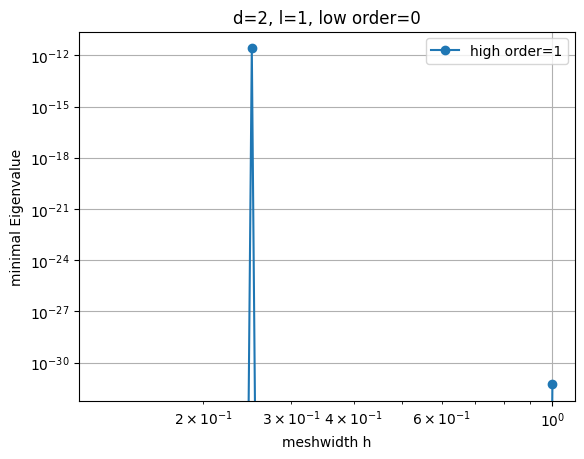

In [47]:
symbols = ['o-','h-.','*:','+-']


fig, ax = plt.subplots()
plt.grid(visible=True)
plt.title(label="d=2, l=1, low order=%i" %low_order)
plt.xlabel('meshwidth h')
plt.ylabel('minimal Eigenvalue')
#plt.loglog(meshwidths,np.power(meshwidths,2),'--k', label=r'$\mathcal{O}(h^{2})$')

lowest_high_Order = low_order + 1
highest_high_order = lowest_high_Order + high_orders
for i in range(lowest_high_Order,highest_high_order):
    plt.loglog(meshwidths,minEV[i-lowest_high_Order,:], symbols[i-lowest_high_Order], label="high order=%i"%i)

plt.legend()
plt.show()



[[0.1018711  0.02804958 0.00668095 0.00174714 0.00045268]]
[[0.1018711  0.02804958 0.00668095 0.00174714 0.00045268]]